In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
class Value:

  def __init__(self, data, _children=(), _op = '', label = ''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data = {self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)

    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad

    out._backward = _backward

    return out

  def __rmul__(self, other):
    return self * other

  def __truediv__(self, other):
    return self * other ** -1

  def __neg__(self):
      return self * -1

  def __sub__(self, other):
    return self + (-other)

  def __radd__(self, other):
    return self + other

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data ** other, (self, ), f'**{other}')

    def _backward():
      self.grad += other * (self.data ** (other - 1)) * out.grad

    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad

    out._backward = _backward
    return out

  def tanh(self):

    out = Value((math.exp(self.data) - math.exp(-1 * self.data)) / (math.exp(self.data) + math.exp(-1 * self.data)), (self, ), 'tanh')

    def _backward():
      self.grad += (1 - (out.data ** 2)) * out.grad

    out._backward = _backward

    return out

  def relu(self):
    out = Value(max(0, self.data), (self, ), 'ReLU')

    def _backward():
      self.grad = max(0, 1 if self.data > 0 else 0) * out.grad

    out._backward = _backward

    return out


  def exp(self):
    out = Value(math.exp(self.data), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad

    out._backward = _backward

    return out

  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0

    for node in reversed(topo):
      node._backward()


In [3]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [4]:
class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1, 1))

  def __call__(self, x):
    act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
    out = act.relu()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

  def zero_grad(self):
    for p in self.parameters():
      p.grad = 0.0


In [5]:
import pickle

def unpickle(file):
  with open(file, 'rb') as fo:
    dict = pickle.load(fo, encoding='bytes')

  return dict


In [6]:
train_dataset = unpickle('cifar-10-python/cifar-10-batches-py/data_batch_1')

labels = unpickle('cifar-10-python/cifar-10-batches-py/batches.meta')

In [7]:
images = train_dataset[b'data']
labels_idxs = train_dataset[b'labels']
label_names = labels[b'label_names']

images = images.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype('float64')

# Normalization to ensure correct gradient calculation.
# Bring 0 - 255 to 0 - 1 float range
images /= 255

# x = x - mean / std
mean = 0.5
std = 0.5

images -= mean
images /= std


/tmp/ipykernel_42287/727910945.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


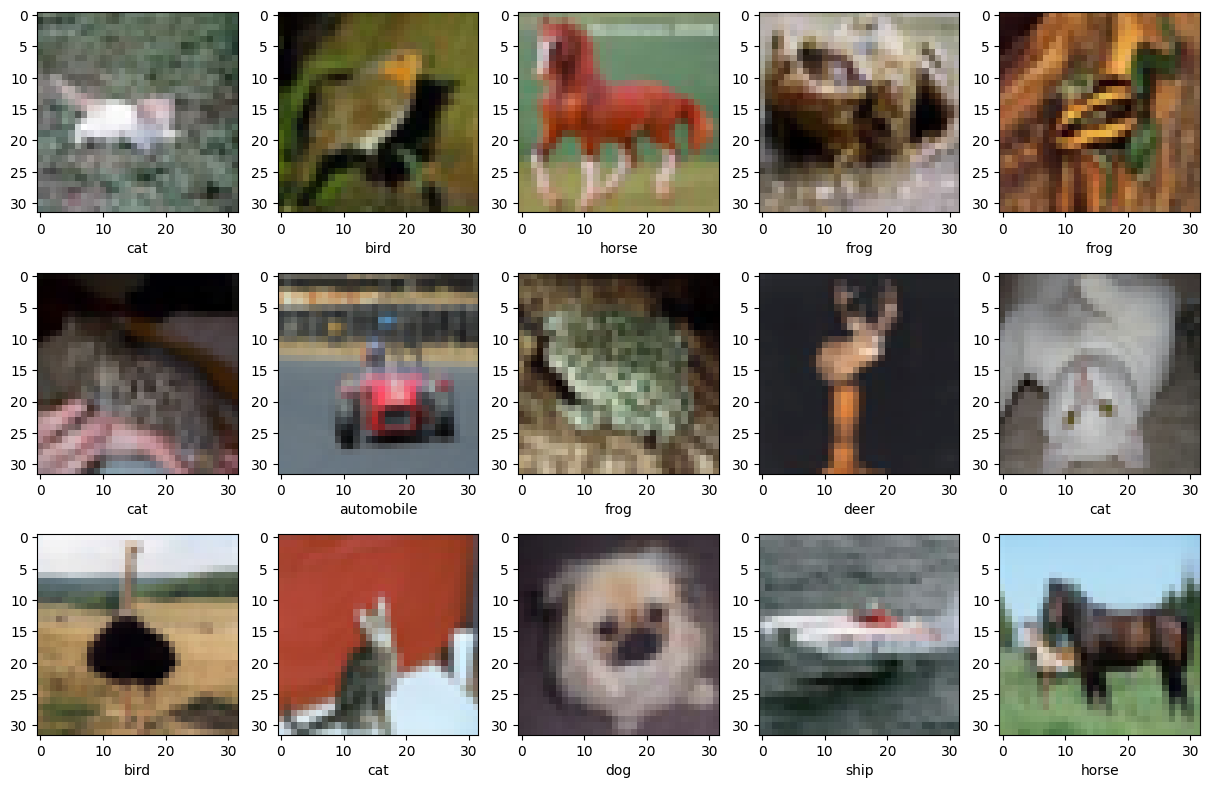

In [8]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (15, 13))

for i in range(15):
  random_idx = int(np.random.randint(10000))

  fig.add_subplot(4, 5, i + 1)

  plt.imshow(images[random_idx] / 2 + 0.5)
  plt.xlabel(label_names[labels_idxs[random_idx]].decode())

fig.show()

In [9]:
training_images = images[:-2000]

testing_images = images[-2000:]

print(training_images.shape)
print(testing_images.shape)

(8000, 32, 32, 3)
(2000, 32, 32, 3)


In [10]:
class Conv2d:

  def __init__(self, in_channels, out_channels, kernel_size, stride = 1):
    kernel_size = self._pair(kernel_size)
    stride = self._pair(stride)

    self.in_channels = in_channels
    self.out_channels = out_channels
    init_weights = np.array([Value(w) for w in np.random.randn(
      out_channels * in_channels * kernel_size[0] * kernel_size[1])])
    self.filters = init_weights.reshape(
      out_channels, in_channels, kernel_size[0], kernel_size[1])
    self.kernel_size = kernel_size
    self.stride = stride

  def __call__(self, X):
    # Forward pass
    output_width = int(((X.shape[1] - self.kernel_size[0]) / self.stride[0]) + 1)
    output_height = int(((X.shape[2] - self.kernel_size[1]) /  self.stride[1]) + 1)

    output = np.zeros((self.out_channels, output_width, output_height))
    
    for index, filter in enumerate(self.filters):
      output_channel = np.zeros((output_width, output_height))
      for input_channel_idx, kernel in enumerate(filter):
        i, j  = 0, 0
        feature_map = np.array([])
        
        kernel_height = self.kernel_size[0]
        kernel_width = self.kernel_size[1]

        input_channel = X[input_channel_idx]

        while i <= input_channel.shape[0] - kernel_height and j <= input_channel.shape[1] - kernel_width:
          feature_map = np.append(
            feature_map, np.sum(np.multiply(
            input_channel[i:i + kernel_height, j : j + kernel_width], kernel)))

          if j + kernel_width == input_channel.shape[1]:
            j = 0
            i += self.stride[0]
          else:
            j += self.stride[1]

        feature_map = np.array([x.data for x in feature_map])
        feature_map = feature_map.reshape(output_height, output_height)
        output_channel += feature_map

      output[index] = output_channel

    return output / self.out_channels

  def _pair(self, val):
    if isinstance(val, int):
      return (val, val)

    return val

  def parameters(self):
    return self.filters.flatten()


convLayer = Conv2d(3, 6, 5)

(32, 32, 3)


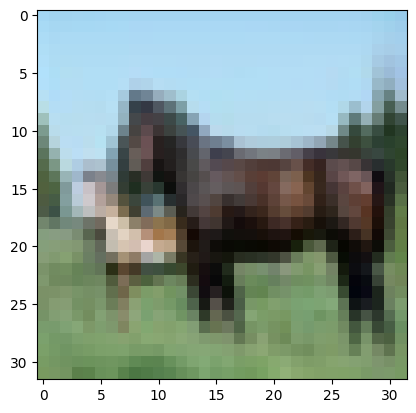

In [11]:

test_image = images[12] / 2 + 0.5
print(test_image.shape)

plt.imshow(test_image)
plt.show()

channeled_test_image = ((test_image - 0.5) / 0.5).transpose(2, 0, 1)

conv1 = convLayer(channeled_test_image)

In [12]:
print(conv1.shape)
print(conv1)

(6, 28, 28)
[[[ 1.01560475  1.02278194  1.02734211 ...  1.00767748  1.00660369
    0.97858294]
  [ 1.0187261   1.02293109  1.05164706 ...  1.03651844  1.02825076
    1.01722136]
  [ 1.03110288  1.03352291  1.06054887 ...  1.04003728  1.04044992
    1.05437814]
  ...
  [ 0.19228631  0.1201561  -0.13349085 ... -0.93796511 -1.03331929
   -0.75900929]
  [ 0.21705345  0.25150722  0.07064672 ... -0.7918679  -0.7744197
   -0.58485458]
  [ 0.25048202  0.40710105  0.29756786 ... -0.52090854 -0.63614399
   -0.42525644]]

 [[-1.52070463 -1.52581618 -1.52756436 ... -1.59377449 -1.62421293
   -1.57518604]
  [-1.58387456 -1.57783997 -1.58079276 ... -1.68057683 -1.70862938
   -1.63408145]
  [-1.62196123 -1.61923735 -1.60805959 ... -1.7320055  -1.83608795
   -1.70853408]
  ...
  [-0.20979543  0.01671658  0.14445242 ...  1.39288067  1.87609322
    1.45380174]
  [-0.24966411 -0.13199173  0.06484556 ...  0.93393323  1.13870223
    1.02168975]
  [-0.12730077 -0.20237944 -0.04725074 ...  0.57300035  0.5412

/tmp/ipykernel_42287/2192450653.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


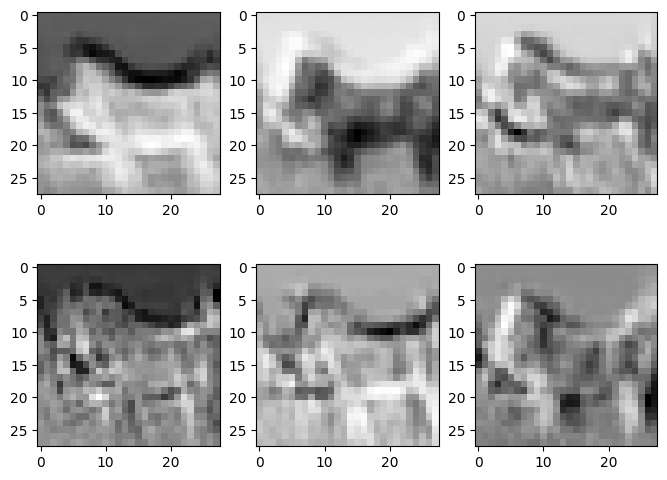

In [13]:
import matplotlib.pyplot as plt

def show_channels(channels):

  fig = plt.figure(figsize = (8, 6))

  for i in range(6):
    fig.add_subplot(2, 3, i + 1)

    plt.imshow(channels[i], cmap = 'Greys')

  fig.show()

show_channels(conv1)

/tmp/ipykernel_42287/2192450653.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


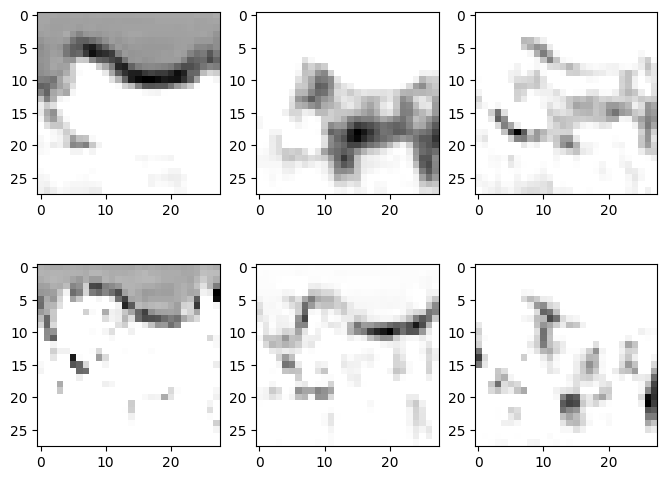

In [14]:
def relu(x):
  return x if x > 0 else 0.0

relu_vectorized = np.vectorize(relu)

x = relu_vectorized(conv1)

show_channels(x)

In [15]:
class MaxPool2D:

  def __init__(self, kernel_size, stride):
    self.kernel_size = self._pair(kernel_size)
    self.stride = self._pair(stride)

  def __call__(self, X):
    # Forward pass
    output_width = int(((X.shape[1] - self.kernel_size[0]) / self.stride[0]) + 1)
    output_height = int(((X.shape[2] - self.kernel_size[1]) /  self.stride[1]) + 1)

    output = np.zeros((X.shape[0], output_width, output_height))
    
    for index in range(X.shape[0]):
      output_channel = np.zeros((output_width, output_height))
      i, j  = 0, 0
      feature_map = np.array([])
      
      input_channel = X[index]

      while i <= input_channel.shape[0] - self.kernel_size[0] and j <= input_channel.shape[1] - self.kernel_size[1]:
        feature_map = np.append(
          feature_map, np.max(
          input_channel[i:i + self.kernel_size[0], j : j + self.kernel_size[1]]))

        if j + self.kernel_size[1] == input_channel.shape[1]:
          j = 0
          i += self.stride[0]
        else:
          j += self.stride[1]

      feature_map = feature_map.reshape(output_height, output_height)
      output_channel += feature_map

      output[index] = output_channel

    return output

  def _pair(self, val):
    if isinstance(val, int):
      return (val, val)

    return val

    

(6, 14, 14)


/tmp/ipykernel_42287/2192450653.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


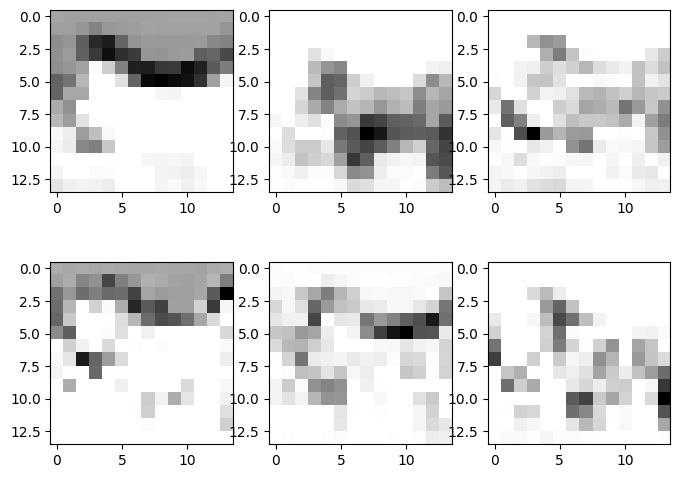

In [16]:
pool = MaxPool2D(2, 2)

pooled_output = pool(x)

print(pooled_output.shape)

show_channels(pooled_output)

In [17]:
conv2 = Conv2d(6, 16, 5)

x = pool(relu_vectorized(conv2(pooled_output)))

print(x)

[[[0.47782082 1.18841161 1.46777279 1.12684503 0.64414089]
  [1.18416492 0.96909051 1.09501488 1.43999483 1.3171772 ]
  [1.00596909 0.24758232 0.72132339 0.88759072 0.83640108]
  [0.56604065 0.51733985 0.6097943  0.39140135 0.3439816 ]
  [0.40474041 0.2373856  0.56166064 0.43101065 0.4928667 ]]

 [[0.         0.08562451 0.01378021 0.         0.        ]
  [0.         0.03215011 0.         0.         0.        ]
  [0.04007625 0.21112661 0.         0.         0.        ]
  [0.         0.07620159 0.76193644 0.97914068 0.39275971]
  [0.         0.13524931 0.90428555 0.85473335 0.02920999]]

 [[1.5499747  1.98554719 1.42526808 1.15319424 1.4028441 ]
  [1.3345125  1.59045256 1.34802596 1.50958008 1.70347621]
  [1.07674907 1.3307002  1.83079213 1.72850996 1.88536521]
  [0.90660626 1.83341879 1.8615566  1.61211242 1.63408441]
  [0.97405177 1.40425941 1.05185542 0.61625226 1.24391347]]

 [[0.32838143 0.66224515 0.81033546 0.45238848 0.40487973]
  [0.57730534 1.98471472 1.57008713 0.51575385 0.7

/tmp/ipykernel_42287/4081368249.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


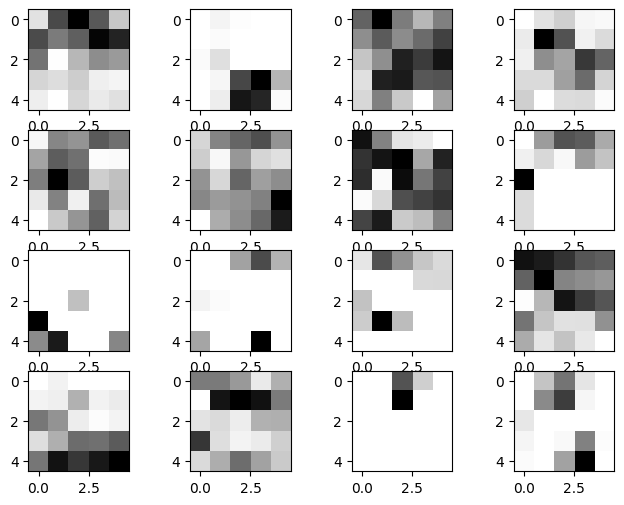

In [18]:
fig = plt.figure(figsize = (8, 6))

for i in range(16):
  fig.add_subplot(4, 4, i + 1)

  plt.imshow(x[i], cmap = 'Greys')

fig.show()

In [19]:
fc = MLP(16 * 5 * 5, [120, 84, 10])

result = [x.data for x in fc(x.flatten())]

result /= np.sum(result)

print(result)


[0.         0.4114768  0.         0.         0.33314651 0.
 0.         0.         0.25537669 0.        ]
